# An Analysis of UK Household Finances using the BoE/NMG Annual Household Survey 2011-2023

This notebook is an analysis of household finances using the 2011-2023 NMG survey, available here: https://www.bankofengland.co.uk/statistics/research-datasets

## Set-up

This notebook was created with Python 3.11.10 and the following libraries:
* pandas = 2.2.3
* matplotlib = 3.9.2
* seaborn = 0.13.2
* scikit-learn = 1.5.2

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

### Read Data

NMG Household Survey

In [2]:
# Read data
excel_file = "boe-nmg-household-survey-data.xlsx"
all_sheets = pd.read_excel(excel_file, sheet_name=None)

# Concatenate sheets into a single df
exclude_sheets = ["Instructions", "Data description", "2011-2023 PID-SUBSID"] 
combined_df = pd.concat(
    [df.assign(year=sheet_name) for sheet_name, df in all_sheets.items() if sheet_name not in exclude_sheets],
    ignore_index=True
)
combined_df['year'] = pd.to_datetime(combined_df['year'], format='%Y')
combined_df.head()

,we_factor,subsid,dsoc,dsocial,fgenage_1,dage,dregion,fgen,qhousing,dhousing,...,spq14d_rank_2,spq14d_rank_3,spq14d_rank_4,spq14d_rank_970,boe93_1,boe93_2,boe93_3,boe93_4,boe93_5,boe93_na
0,1.176425,22007620.0,2.0,1.0,23,1,3,2,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.931040,22238715.0,5.0,5.0,22,1,3,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.181808,20404925.0,2.0,1.0,59,5,3,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000213,21839916.0,5.0,5.0,21,1,9,1,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.913671,23091998.0,4.0,4.0,24,1,1,2,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Inflation Rate (ONS)

In [54]:
# Read inflation data
inflation_df = pd.read_csv("data/inflation-2011-2023.csv")
inflation_df = inflation_df.rename(columns={'Title': 'date', 'CPIH ANNUAL RATE 00: ALL ITEMS 2015=100': 'cpih_annual_rate'}).copy()
inflation_df['date'] = pd.to_datetime(inflation_df['date'], format='%Y %b')
# Filter for years 2011 to 2023 to align with survey data
start_date = pd.to_datetime('2011-01-01')
end_date = pd.to_datetime('2023-12-31')
inflation_df = inflation_df[(inflation_df['date'] >= start_date) & (inflation_df['date'] <= end_date)].reset_index(drop=True).copy()
# Sort
inflation_df = inflation_df.sort_values(by='date', ascending=False).reset_index(drop=True).copy()

Bank Rate (BoE)

In [52]:
# Read interest rate data
interest_df = pd.read_csv("data/bank-rate.csv")
interest_df = interest_df.rename(columns={'Date Changed': 'date', 'Rate': 'bank_rate'}).copy()
interest_df['date'] = pd.to_datetime(interest_df['date'], format='%d %b %y')
# Filter for years 2011 to 2023 to align with survey data
interest_df = interest_df[(interest_df['date'] >= start_date) & (interest_df['date'] <= end_date)].reset_index(drop=True).copy()
# Add value for 01-01-2011 to ensure data can be plotted all the way back
new_row = {'date': pd.to_datetime('2011-01-01'), 'bank_rate': 0.25}
interest_df = pd.concat([interest_df,pd.DataFrame([new_row])], ignore_index=True).copy()

## Data Processing

### Understanding the availability of data
This section seeks to understand the availability of different data fields across the span of the period of the study. 

In [5]:
def count_blanks_and_non_blanks(fields: list):
    """
    Counts the number of blank and non-blank values for each column in the input list, grouped by 'year'.

    Parameters:
        fields (list): List of column names to analyze.
    """
    for field in fields:
        if field not in combined_df.columns:
            print(f"Column '{field}' not found in the DataFrame. Skipping...")
            continue  # Skip to the next column
        
        print(f"\nSummary for {field}:\n")
        
        blank_non_blank_summary = combined_df.groupby('year')[field].apply(
            lambda x: pd.Series({
                'Blanks': x.isnull().sum(),
                'Non-Blanks': x.notnull().sum()
            })
        ).unstack()

        # Display results
        print(blank_non_blank_summary)

In [6]:
# Availability of demographic data
#   - dage : age (single band)
#   - fgenage_1 : age (free)
#   - fgen : gender (single band)
#   - qregion : region in UK (single band) (more detail than dregion)
#   - dregion : region in UK (single band)
#   - qual : highest educational attainment (single band)
#   - nochildren : number of children (free: int)
demograph_fields = ['dage', 'fgenage_1', 'fgen', 'qregion', 'dregion', 'qual', 'nochildren']
count_blanks_and_non_blanks(demograph_fields)


Summary for dage:

            Blanks  Non-Blanks
year                          
2011-01-01       0         995
2012-01-01       0        4003
2013-01-01       0        6006
2014-01-01       0        6001
2015-01-01       0        6007
2016-01-01       0        6011
2017-01-01       0        6018
2018-01-01       0        6000
2019-01-01       0        6051
2020-01-01       0        6032
2021-01-01       0        6051
2022-01-01       0        6053
2023-01-01       0        5914

Summary for fgenage_1:

            Blanks  Non-Blanks
year                          
2011-01-01       0         995
2012-01-01       0        4003
2013-01-01       0        6006
2014-01-01       0        6001
2015-01-01       0        6007
2016-01-01       0        6011
2017-01-01       0        6018
2018-01-01       0        6000
2019-01-01       0        6051
2020-01-01       0        6032
2021-01-01       0        6051
2022-01-01       0        6053
2023-01-01       0        5914

Summary for fgen:

     

In [7]:
# Availability of income data
#   - qincome : gross household income (single band)
#   - qincomev1 : gross household income (single band) (same as above)
#   - qincomev2 : gross income per individual in household (single band)
#   - qbe01 : 'disposable' income (single band) 
#   - qbe01free_1 : 'disposable' income (free) 
#   - mthincome : combined household monthly income (single band)
#   - overallincomecomb : overal combined household income (single band)
income_fields = ['qincome', 'qincomev1', 'qincomev2_1_3', 'qincomefreev2_n_3', 'mthincome', 'overallincomecomb', 'qbe01', 'qbe01free_1']
count_blanks_and_non_blanks(income_fields)


Summary for qincome:

            Blanks  Non-Blanks
year                          
2011-01-01       0         995
2012-01-01       0        4003
2013-01-01       0        6006
2014-01-01       0        6001
2015-01-01    6007           0
2016-01-01    6011           0
2017-01-01    6018           0
2018-01-01    6000           0
2019-01-01    6051           0
2020-01-01    6032           0
2021-01-01    6051           0
2022-01-01    6053           0
2023-01-01    5914           0

Summary for qincomev1:

            Blanks  Non-Blanks
year                          
2011-01-01     995           0
2012-01-01    4003           0
2013-01-01    6006           0
2014-01-01    6001           0
2015-01-01    2877        3130
2016-01-01    6011           0
2017-01-01    6018           0
2018-01-01    6000           0
2019-01-01    6051           0
2020-01-01    6032           0
2021-01-01    6051           0
2022-01-01    6053           0
2023-01-01    5914           0

Summary for qincomev2

In [8]:
# Availability of savings data
#   - be2a : monthly savings (single band)
#   - be2afree_1 : monthly savings (free) (also be2afree_c)
#   - soa1 : change in monthly savings over past year (single band)
#   - soa1b : reason behind change in monthly savings IF DECREASE (multi band)
#   - soa1c : reason behind change in monthly savings IF INCREASE (multi band)
#   - boe65a : total household savings

savings_fields = ['be2a', 'be2afree_1', 'soa1', 'boe65a']
count_blanks_and_non_blanks(savings_fields)


Summary for be2a:

            Blanks  Non-Blanks
year                          
2011-01-01       0         995
2012-01-01       0        4003
2013-01-01       0        6006
2014-01-01       0        6001
2015-01-01       0        6007
2016-01-01       0        6011
2017-01-01       0        6018
2018-01-01       0        6000
2019-01-01       0        6051
2020-01-01       0        6032
2021-01-01       0        6051
2022-01-01       0        6053
2023-01-01       0        5914

Summary for be2afree_1:

            Blanks  Non-Blanks
year                          
2011-01-01     995           0
2012-01-01    4003           0
2013-01-01    3280        2726
2014-01-01    1976        4025
2015-01-01    2144        3863
2016-01-01    2457        3554
2017-01-01    2379        3639
2018-01-01    2689        3311
2019-01-01    2506        3545
2020-01-01    2733        3299
2021-01-01    2482        3569
2022-01-01    2389        3664
2023-01-01    2292        3622

Summary for soa1:

    

In [9]:
# Availability of spending data
#   - boe56 : cost of bills (single band)
#   - BOE56free : cost of bills (free)

spending_fields = ['boe56', 'BOE56free_1']
count_blanks_and_non_blanks(spending_fields)


Summary for boe56:

            Blanks  Non-Blanks
year                          
2011-01-01     995           0
2012-01-01    4003           0
2013-01-01    6006           0
2014-01-01     896        5105
2015-01-01    6007           0
2016-01-01    6011           0
2017-01-01    6018           0
2018-01-01    6000           0
2019-01-01    6051           0
2020-01-01    6032           0
2021-01-01    6051           0
2022-01-01    6053           0
2023-01-01    5914           0

Summary for BOE56free_1:

            Blanks  Non-Blanks
year                          
2011-01-01     995           0
2012-01-01    4003           0
2013-01-01    6006           0
2014-01-01    2404        3597
2015-01-01    6007           0
2016-01-01    6011           0
2017-01-01    6018           0
2018-01-01    6000           0
2019-01-01    6051           0
2020-01-01    6032           0
2021-01-01    6051           0
2022-01-01    6053           0
2023-01-01    5914           0


In [10]:
# Availability of housing data
#   - be04 : house value (single band)
#   - be04free_1 : house value (free) (also be04free_c)
#   - qhousing : housing type (single band) (more detail than dhousing)
#   - dhousing : housing type (single band) 
#   - be44 : type of mortage (multi band) 
#   - be07 : amount left to pay on mortgage (single band) 
#   - be07free : amount left to pay on mortgage (free)
#   - mh01 : taken mortgage payment holiday this year? (single band) 
#   - be08 : value of last monthly payment on mortgage (single band) 
#   - be08free : value of last monthly payment on mortgage (single band) (also be08free_c)
#   - overallbe08 : overall monthly mortgage installment (single band)
#   - boe47 : interest rate on mortgage (single band)

housing_fields = ['be04', 'be04free_1', 'qhousing', 'dhousing', 'be44', 'be07', 'be07free_1', 'mh01', 'be08', 'be08free_1', 'overallbe08', 'boe47']
count_blanks_and_non_blanks(housing_fields)


Summary for be04:

            Blanks  Non-Blanks
year                          
2011-01-01     629         366
2012-01-01    2753        1250
2013-01-01    4153        1853
2014-01-01    3423        2578
2015-01-01    4228        1779
2016-01-01    4281        1730
2017-01-01    4416        1602
2018-01-01    4181        1819
2019-01-01    4243        1808
2020-01-01    4299        1733
2021-01-01    4303        1748
2022-01-01    2271        3782
2023-01-01    2278        3636

Summary for be04free_1:

            Blanks  Non-Blanks
year                          
2011-01-01     995           0
2012-01-01    4003           0
2013-01-01    5008         998
2014-01-01    3929        2072
2015-01-01    4588        1419
2016-01-01    4731        1280
2017-01-01    4827        1191
2018-01-01    4709        1291
2019-01-01    4683        1368
2020-01-01    4649        1383
2021-01-01    4743        1308
2022-01-01    3185        2868
2023-01-01    3046        2868

Summary for qhousing:



In [11]:
# Availability of market expectations data
# - boe39a_1 : expected BoE interest rate in 1 years time (single band)
# - boe39a_2 : expected BoE interest rate in 2 years time (single band)
# - boe39a_3 : expected BoE interest rate in 5 years time (single band)
market_fields = ['boe39a_1', 'boe39a_2', 'boe39a_3']
count_blanks_and_non_blanks(market_fields)


Summary for boe39a_1:

            Blanks  Non-Blanks
year                          
2011-01-01     995           0
2012-01-01    4003           0
2013-01-01    6006           0
2014-01-01    6001           0
2015-01-01    6007           0
2016-01-01    6011           0
2017-01-01    6018           0
2018-01-01    6000           0
2019-01-01    6051           0
2020-01-01    6032           0
2021-01-01       0        6051
2022-01-01       0        6053
2023-01-01       0        5914

Summary for boe39a_2:

            Blanks  Non-Blanks
year                          
2011-01-01     995           0
2012-01-01    4003           0
2013-01-01    6006           0
2014-01-01    6001           0
2015-01-01    6007           0
2016-01-01    6011           0
2017-01-01    6018           0
2018-01-01    6000           0
2019-01-01    6051           0
2020-01-01    6032           0
2021-01-01       0        6051
2022-01-01       0        6053
2023-01-01       0        5914

Summary for boe39a_3:

### Data transformation

Midpoint imputations

In [12]:
# Midpoint imputations - generally greater response rate for banded than free-text responses
def calc_band_midpoint(band_column: str, band_mapping: dict):
    """
    Calculate the midpoint for a band based on its associated numeric value.
    """
    return band_mapping.get(band_column, np.nan)

In [13]:
# Income
# mthincome - monthly gross income per household
mthincome_band_mapping = {
    0: -1,                        # less than £0
    1: 0,                         # £0
    2: 104.5,                     # £1 to £208
    3: 291.5,                     # £208 to £375
    4: 458.5,                     # £375 to £542
    5: 583.5,                     # £542 to £625
    6: 708.5,                     # £625 to £792
    7: 875.0,                     # £792 to £958
    8: 1041.5,                    # £958 to £1125
    9: 1208.5,                    # £1125 to £1292
    10: 1375.0,                   # £1292 to £1458
    11: 1770.5,                   # £1458 to £2083
    12: 2500.0,                   # £2083 to £2917
    13: 3333.5,                   # £2917 to £3750
    14: 4166.5,                   # £3750 to £4583
    15: 5416.5,                   # £4583 to £6250
    16: 7291.5,                   # £6250 to £8333
    17: 8333,                     # £8333 or more
    18: np.nan                    # Don't know/Not stated
}

combined_df['x_mthincome_midpoint'] = combined_df['mthincome'].apply(calc_band_midpoint, band_mapping=mthincome_band_mapping)
# Calc annual income from monthly value
combined_df['x_annual_income'] = combined_df['x_mthincome_midpoint']*12

/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_12273/2960754470.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['x_mthincome_midpoint'] = combined_df['mthincome'].apply(calc_band_midpoint, band_mapping=mthincome_band_mapping)
/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_12273/2960754470.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['x_annual_income'] = combined_df['x_mthincome_midpoint']*12


In [14]:
# Savings
be2a_band_mapping = {
    1: 0,                        # None
    2: 12.5,                     # £1 - £24
    3: 37.0,                     # £25-£49
    4: 74.5,                     # £50-£99
    5: 124.5,                    # £100 - £149
    6: 174.5,                    # £150 - £199
    7: 224.5,                    # £200 - £249
    8: 274.5,                    # £250 - £299
    9: 324.5,                    # £300 - £349
    10: 374.5,                   # £350 - £399
    11: 424.5,                   # £400 - £449
    12: 474.5,                   # £450 - £499
    13: 549.5,                   # £500 - £599
    14: 649.5,                   # £600 - £699
    15: 749.5,                   # £700 - £799
    16: 849.5,                   # £800 - £899
    17: 949.5,                   # £900 - £999
    18: 1249.5,                  # £1,000 - £1,499
    19: 1749.5,                  # £1,500 - £1,999
    20: 2000,                    # £2,000 or more
    97: np.nan,                  # Don’t know
    96: np.nan                   # Prefer not to state
}

# Apply the function to calculate midpoints
combined_df['x_be2a_midpoint'] = combined_df['be2a'].apply(calc_band_midpoint, band_mapping=be2a_band_mapping)
# Calc annual savings from monthly value
combined_df['x_annual_savings'] = combined_df['x_be2a_midpoint']*12

# Total savings - boe65a
boe65a_band_mapping = {
    1: 0,                         # I have no savings
    2: 250,                       # £1 - £499
    3: 750,                       # £500 - £999
    4: 1500,                      # £1,000 - £1,999
    5: 2500,                      # £2,000 - £2,999
    6: 3500,                      # £3,000 - £3,999
    7: 4500,                      # £4,000 - £4,999
    8: 5500,                      # £5,000 - £5,999
    9: 6500,                      # £6,000 - £6,999
    10: 7500,                     # £7,000 - £7,999
    11: 8500,                     # £8,000 - £8,999
    12: 9500,                     # £9,000 - £9,999
    13: 11250,                    # £10,000 - £12,499
    14: 13750,                    # £12,500 - £14,999
    15: 16250,                    # £15,000 - £17,499
    16: 18750,                    # £17,500 - £19,999
    17: 22500,                    # £20,000 - £24,999
    18: 27500,                    # £25,000 - £29,999
    19: 32500,                    # £30,000 - £34,999
    20: 37500,                    # £35,000 - £39,999
    21: 42500,                    # £40,000 - £44,999
    22: 47500,                    # £45,000 - £49,999
    23: 62500,                    # £50,000 - £74,999
    24: 87500,                    # £75,000 - £99,999
    25: 125000,                   # £100,000 - £149,999
    26: 150000,                   # More than £150,000
    97: None,                     # Don’t know
    96: None                      # Prefer not to state
}

combined_df['x_boe65a'] = combined_df['boe65a'].apply(calc_band_midpoint, band_mapping=boe65a_band_mapping)

/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_12273/973066968.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['x_be2a_midpoint'] = combined_df['be2a'].apply(calc_band_midpoint, band_mapping=be2a_band_mapping)
/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_12273/973066968.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['x_annual_savings'] = combined_df['x_be2a_midpoint']*12
/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_12273/973066968.py:64: PerformanceWarnin

Variable mapping

In [15]:
# Age - dage
age_mapping = {
    1: '18 - 24',
    2: '25 - 34',
    3: '35 - 44',
    4: '45 - 54',
    5: '55 - 64',
    6: '65+'
}
combined_df['dage'] = combined_df['dage'].replace(age_mapping).copy()

# Housing onwnership type - qhousing
housing_ownership_mapping = {
    1: 'Being bought on a mortgage',
    2: 'Owned outright by household',
    3: 'Rented from local authority',
    4: 'Rented from a private landlord',
    5: 'Belongs to housing association',
    98: 'Other (please specify)',
    96: 'Prefer not to state'
}
combined_df['qhousing'] = combined_df['qhousing'].replace(housing_ownership_mapping).copy()

# Region - qregion
qregion_band_mapping = {
    1: 'North',
    2: 'North West',
    3: 'Yorks & Humberside',
    4: 'West Midlands',
    5: 'East Midlands',
    6: 'East Anglia',
    7: 'South West',
    8: 'South East',
    9: 'Greater London',
    10: 'Wales',
    11: 'Scotland',
    12: 'Northern Ireland',
    13: 'Non UK',
    99: 'Not On Map'
}
combined_df['qregion'] = combined_df['qregion'].apply(calc_band_midpoint, band_mapping=qregion_band_mapping).copy()

# Gender -fgen
fgen_band_mapping = {
    1: 'Male',
    2: 'Female'
}
combined_df['fgen'] = combined_df['fgen'].apply(calc_band_midpoint, band_mapping=fgen_band_mapping).copy()


## Summary Trends - Savings and market conditions

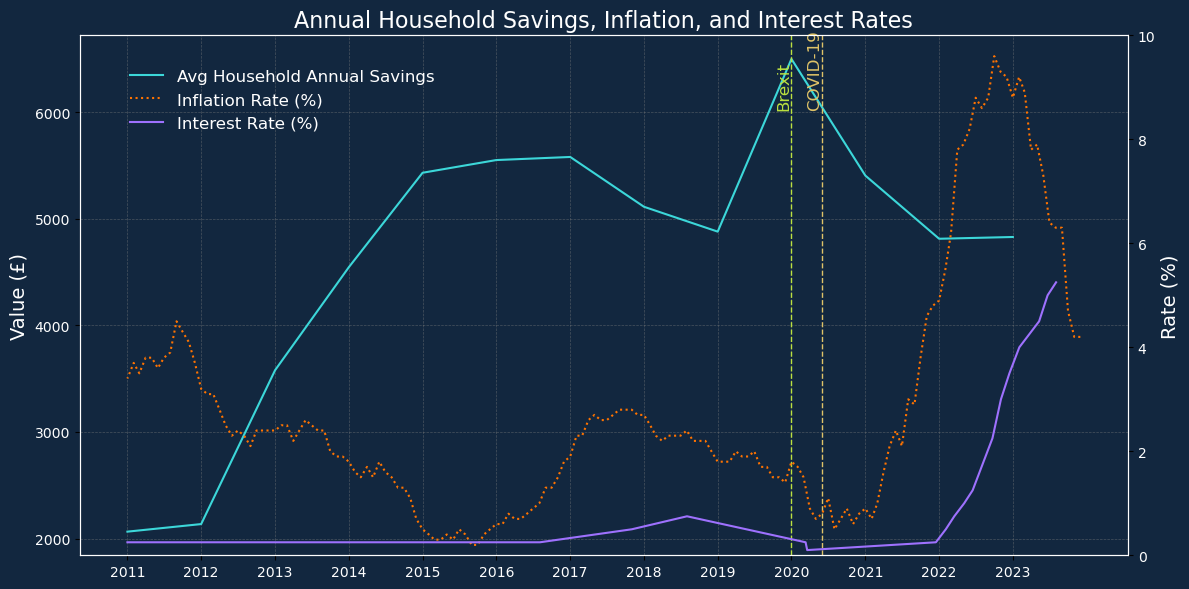

In [50]:
# Data preparation
average_savings_per_year = combined_df.groupby('year')['x_annual_savings'].mean()

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average savings on the primary y-axis
ax1.plot(
    average_savings_per_year.index,
    average_savings_per_year.values,
    linestyle='-',
    color='#3CD7D9',
    label='Avg Household Annual Savings'
)

# Set labels for the primary y-axis
ax1.set_ylabel('Value (£)', fontsize=14, color='white')
ax1.tick_params(axis='y', labelcolor='white')
ax1.set_xlabel('', fontsize=14, color='white')
ax1.tick_params(axis='x', labelcolor='white')

# Format x-axis to display years only
ax1.set_xticks(average_savings_per_year.index)
ax1.set_xticklabels(average_savings_per_year.index.strftime('%Y'), rotation=0, ha='center', color='white')

# Add a secondary y-axis for inflation and interest rates
ax2 = ax1.twinx()
ax2.plot(
    inflation_df['date'],
    inflation_df['cpih_annual_rate'],
    linestyle=':',
    color='#FF7300',
    label='Inflation Rate (%)'
)
ax2.plot(
    interest_df['date'],
    interest_df['bank_rate'],
    linestyle='-',
    color='#9E71FE',
    label='Interest Rate (%)'
)

# Set the range for the secondary y-axis
ax2.set_ylim(0, 10)
ax2.set_ylabel('Rate (%)', fontsize=14, color='white')
ax2.tick_params(axis='y', labelcolor='white')

# Add gridlines to the primary axis
ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legends
fig.legend(
    loc='upper left',
    bbox_to_anchor=(0.1, 0.9),
    frameon=False,
    fontsize=12,
    labelcolor='white'
)

# Add vertical lines for events
covid_date = datetime(2020, 6, 1)  # Start of COVID-19 pandemic
brexit_date = datetime(2020, 1, 1)  # Brexit date

ax1.axvline(covid_date, color='#DFC368', linestyle='--', linewidth=1)
ax1.text(covid_date, ax1.get_ylim()[1] * 0.9, 'COVID-19', color='#DFC368', fontsize=12, rotation=90, ha='right')

ax1.axvline(brexit_date, color='#BBE140', linestyle='--', linewidth=1)
ax1.text(brexit_date, ax1.get_ylim()[1] * 0.9, 'Brexit', color='#BBE140', fontsize=12, rotation=90, ha='right')

# Add a title
plt.title('Annual Household Savings, Inflation, and Interest Rates', fontsize=16, color='white')

# Set the background color for both axes
ax1.set_facecolor('#12273F')
ax2.set_facecolor('#12273F')
fig.patch.set_facecolor('#12273F')

# Adjust spines and ticks for better contrast
for spine in ax1.spines.values():
    spine.set_color('white')
for spine in ax2.spines.values():
    spine.set_color('white')

# Save the plot to file
plt.savefig('summary_with_events.png', bbox_inches='tight', facecolor=fig.get_facecolor())

# Show the plot
plt.tight_layout()
plt.show()

## Savings

In [17]:
def plot_savings(df: pd.DataFrame, grouping: str, savings_var: str):
    """
    Function to standardise plots for savings rates.
    """
    # Group the data
    grouped_data = df.groupby(['year', grouping])[savings_var].mean().reset_index()

    # Filter out unwanted categories if present
    unwanted_values = ['Other', 'Other (please specify)', 'Prefer not to state']
    grouped_data = grouped_data[~grouped_data[grouping].isin(unwanted_values)]

    # Special handling for 'nochildren'
    hue_order = None
    if grouping == 'nochildren':
        grouped_data['nochildren'] = grouped_data['nochildren'].astype(int).astype('category')
        children_range = [0, 1, 2, 3]
        grouped_data = grouped_data[grouped_data['nochildren'].isin(children_range)]
        hue_order = children_range  # Define order for hue categories

    # Set custom colors (aqua > orange > purple > gold > green > pink > azure > yellow > peach > red)
    custom_palette = [
        '#3CD7D9',  # Aqua
        '#FF7300',  # Orange
        '#9E71FE',  # Purple
        '#D4AF37',  # Gold
        '#00C957',  # Green
        '#FFC0CB',  # Pink
        '#4682B4',  # Azure
        '#FFD700',  # Yellow
        '#FFDAB9',  # Peach
        '#FF0000'   # Red
    ]
    sns.set_palette(custom_palette)

    # Plot the data
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=grouped_data,
        x='year',
        y=savings_var,
        hue=grouping,
        hue_order=hue_order
    )

    # Customize plot appearance
    title = 'Average Annual Household Savings' if savings_var == 'x_annual_savings' else 'Total Household Savings'
    ylabel = 'Annual savings (£)' if savings_var == 'x_annual_savings' else 'Total savings (£)'

    plt.title(title, fontsize=14, color='white')
    plt.ylabel(ylabel, fontsize=12, color='white')
    plt.xlabel('', fontsize=12, color='white')
    legend = plt.legend(
        title=grouping,
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        facecolor='#12273F',
        edgecolor='#12273F',
        title_fontsize=12,
        labelcolor='white',
    )
    legend.get_title().set_color('white')
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')

    # Change the colour of the box around the chart
    ax = plt.gca()
    ax.spines['top'].set_color('#12273F')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('#12273F')

    # Remove gridlines
    plt.grid(False)

    # Set background colour
    plt.gca().set_facecolor('#12273F')  # Background color of the plot
    plt.gcf().set_facecolor('#12273F')  # Background color of the figure

    # Save the plot
    file_name = f"{savings_var}_{grouping}.png".replace(" ", "_")
    plt.savefig(file_name)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

### Region

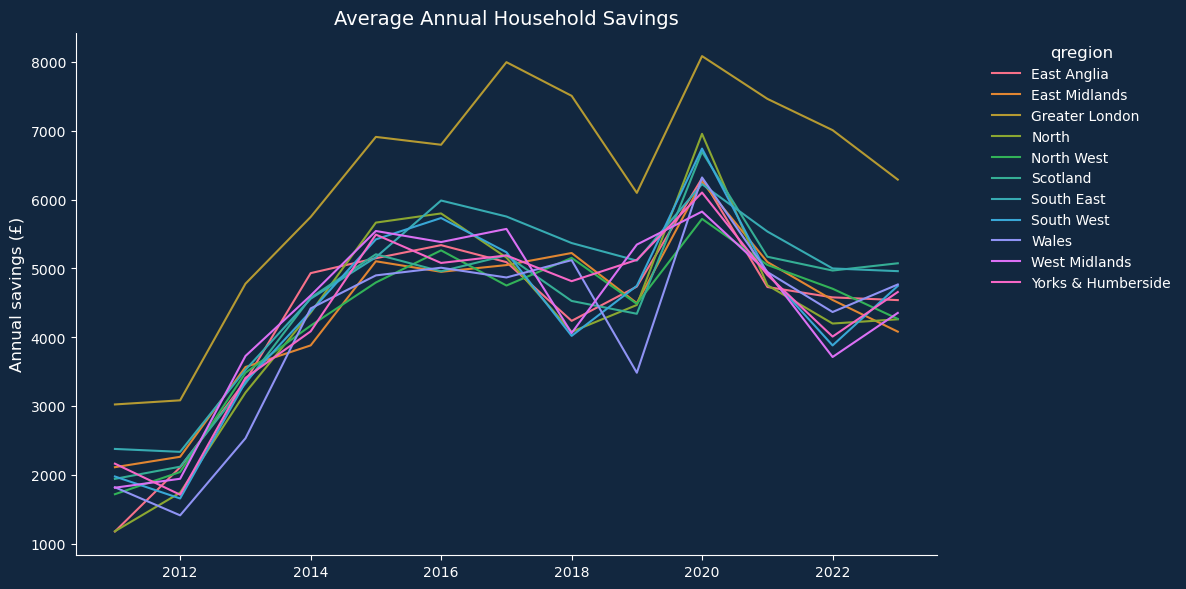

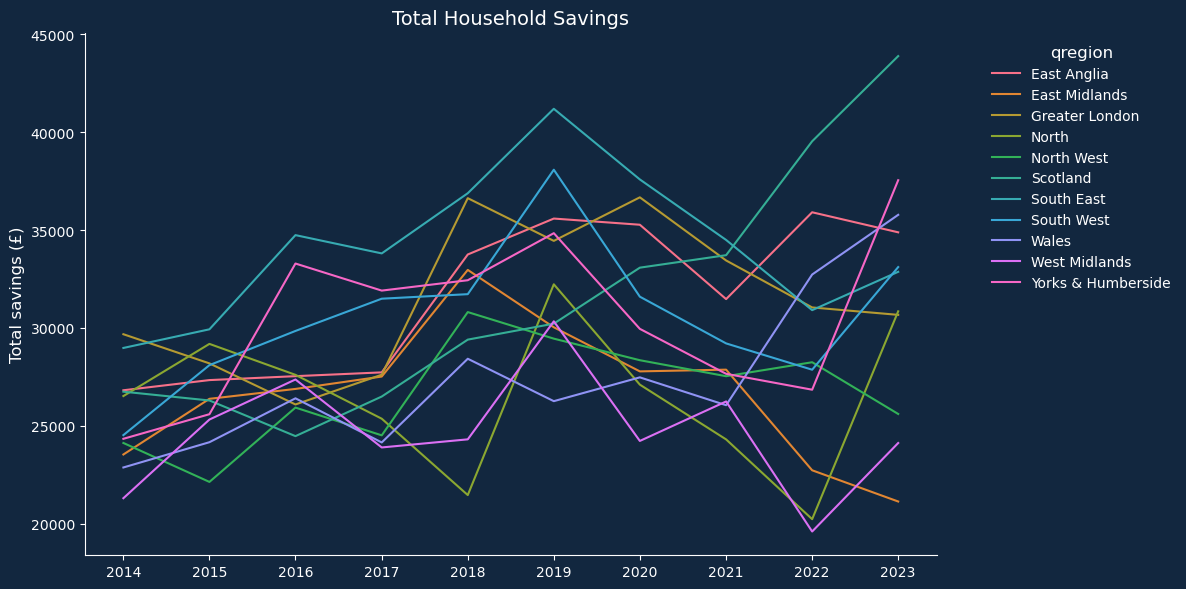

In [18]:
plot_savings(df = combined_df,
                              grouping = 'qregion',
                              savings_var = 'x_annual_savings')
plot_savings(df = combined_df,
                              grouping = 'qregion',
                              savings_var = 'x_boe65a')

In [19]:
# Group the data
grouped_data = combined_df.groupby(['year', 'qregion'])['x_annual_savings'].mean().reset_index()

# Filter out unwanted categories if present
unwanted_values = ['Other', 'Other (please specify)', 'Prefer not to state']
grouped_data = grouped_data[~grouped_data['qregion'].isin(unwanted_values)]

d = grouped_data.groupby('qregion').mean().reset_index()
print(d)

               qregion                          year  x_annual_savings
0          East Anglia 2016-12-31 14:46:09.230769152       4329.102709
1        East Midlands 2016-12-31 14:46:09.230769152       4354.116587
2       Greater London 2016-12-31 14:46:09.230769152       6213.924527
3                North 2016-12-31 14:46:09.230769152       4292.266252
4           North West 2016-12-31 14:46:09.230769152       4275.934790
5             Scotland 2016-12-31 14:46:09.230769152       4467.604221
6           South East 2016-12-31 14:46:09.230769152       4760.694876
7           South West 2016-12-31 14:46:09.230769152       4368.727391
8                Wales 2016-12-31 14:46:09.230769152       4150.016731
9        West Midlands 2016-12-31 14:46:09.230769152       4371.000315
10  Yorks & Humberside 2016-12-31 14:46:09.230769152       4363.620314


### Gender

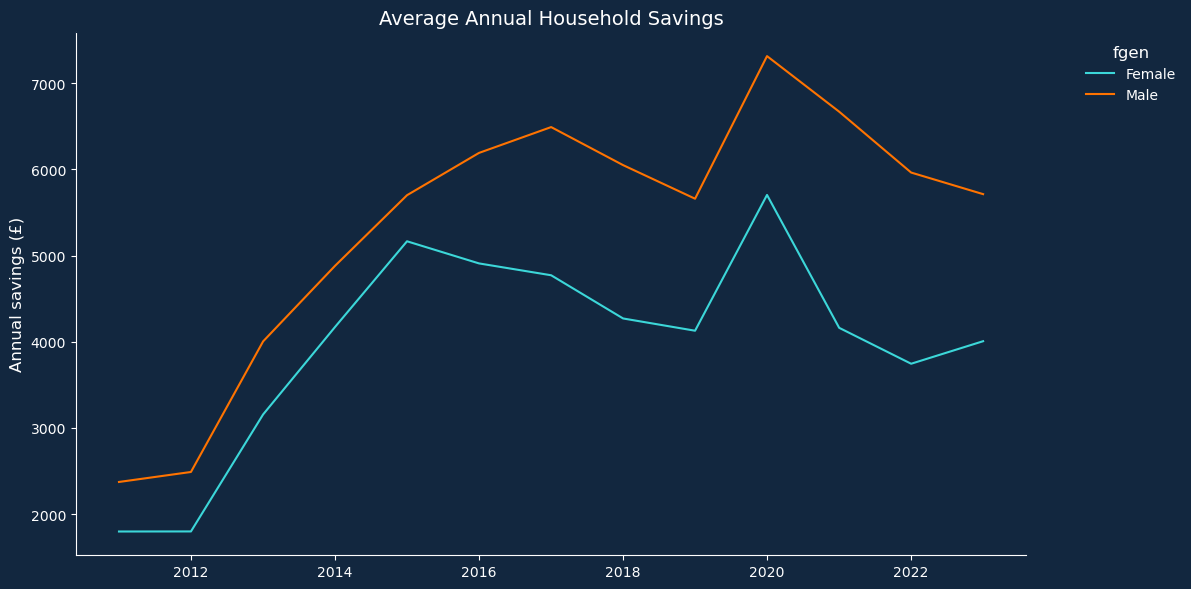

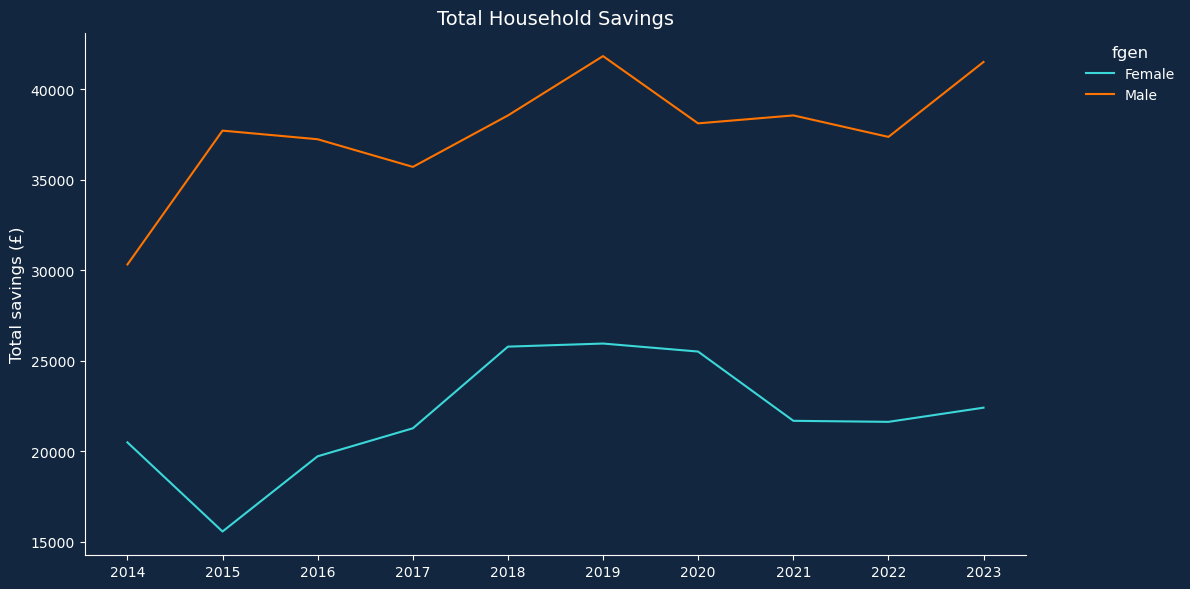

In [20]:
plot_savings(df = combined_df,
                              grouping = 'fgen',
                              savings_var = 'x_annual_savings')
plot_savings(df = combined_df,
                              grouping = 'fgen',
                              savings_var = 'x_boe65a')

### Age

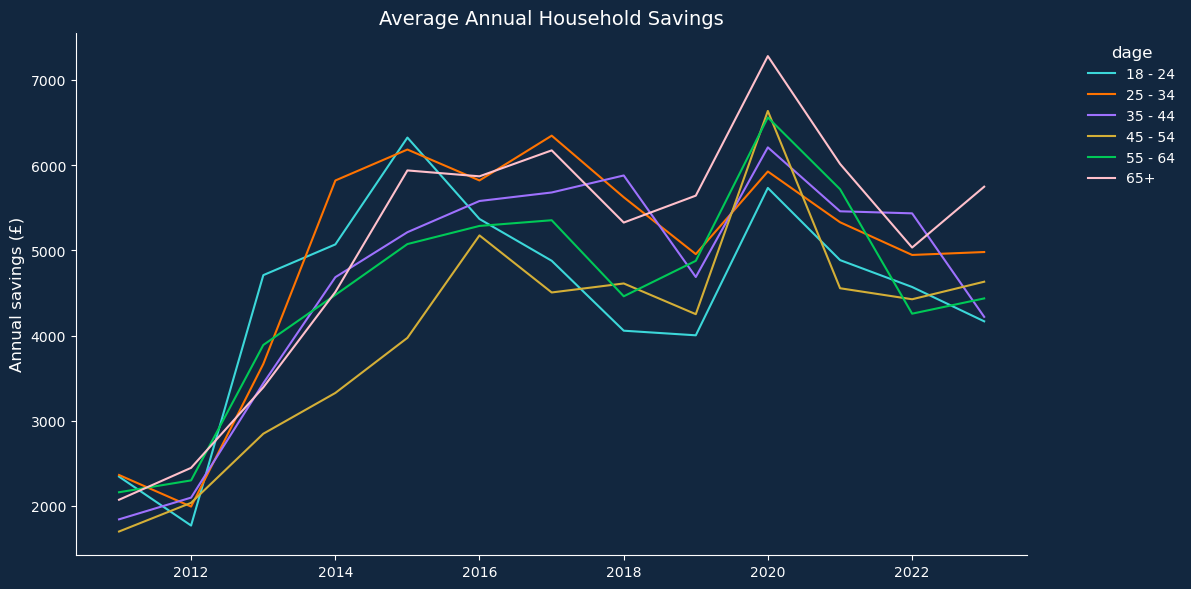

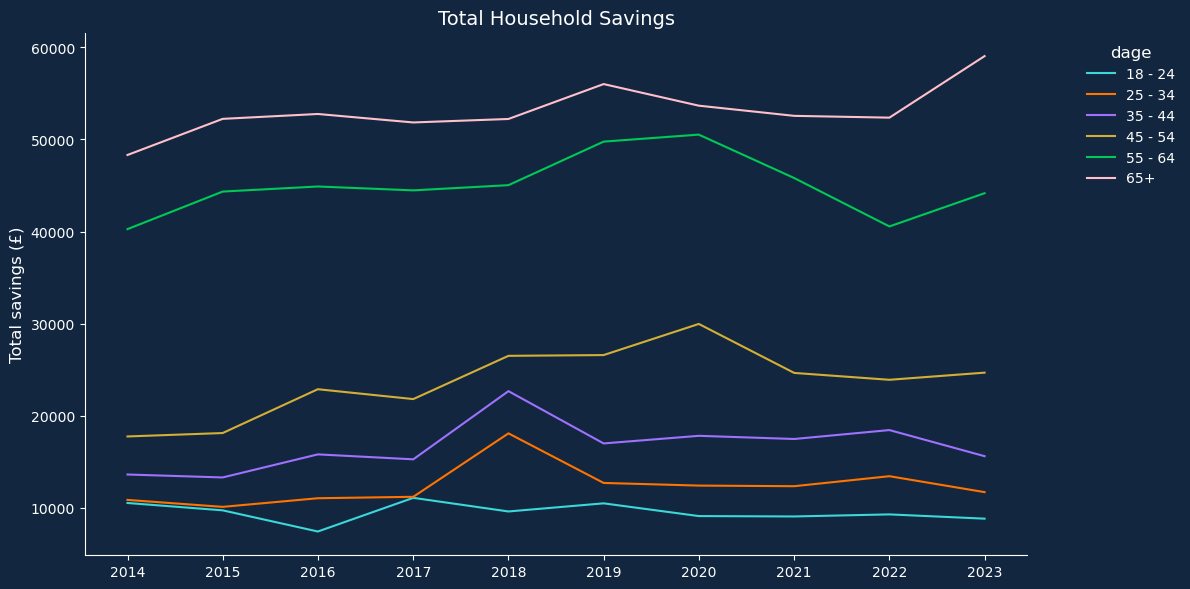

In [21]:
plot_savings(df = combined_df,
                              grouping = 'dage',
                              savings_var = 'x_annual_savings')
plot_savings(df = combined_df,
                              grouping = 'dage',
                              savings_var = 'x_boe65a')

### Housing type

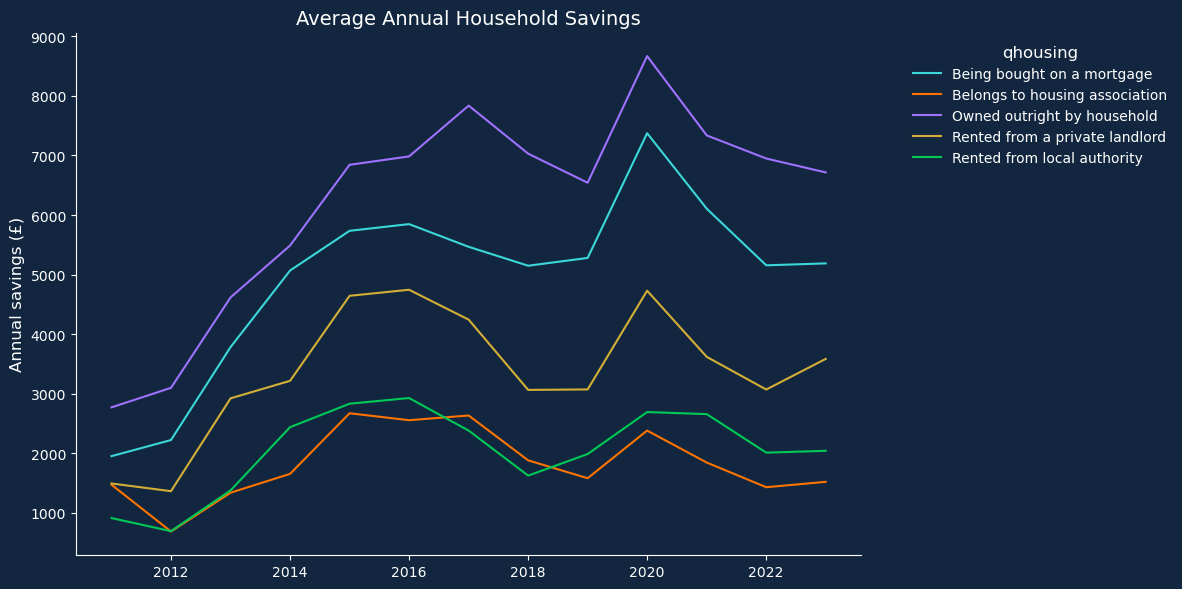

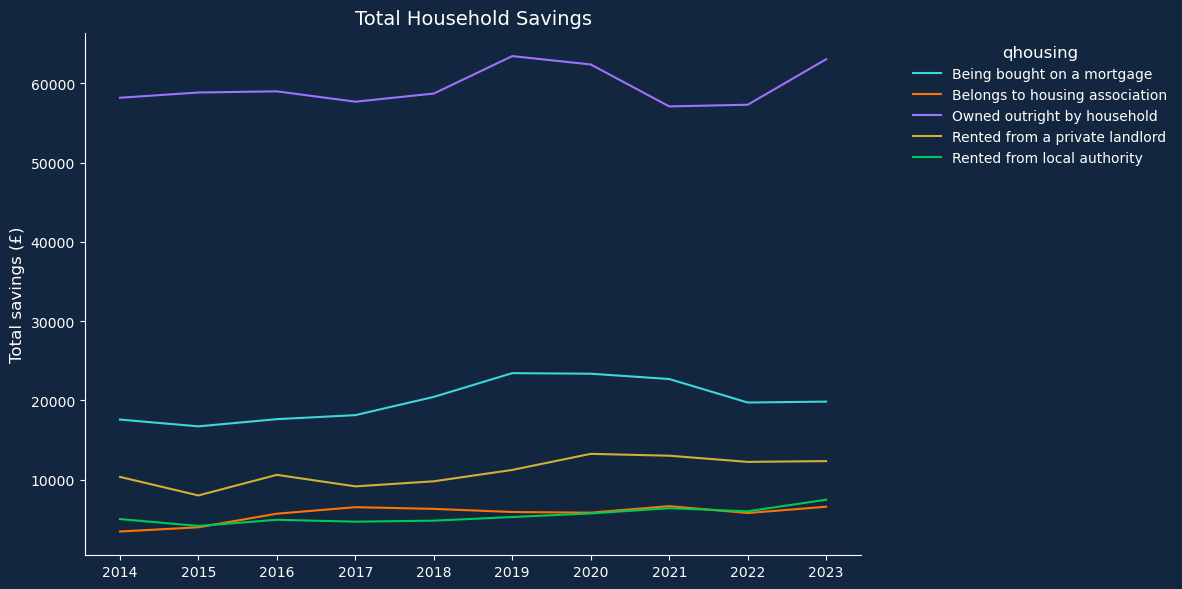

In [22]:
plot_savings(df = combined_df,
                              grouping = 'qhousing',
                              savings_var = 'x_annual_savings')
plot_savings(df = combined_df,
                              grouping = 'qhousing',
                              savings_var = 'x_boe65a')

### Number of children

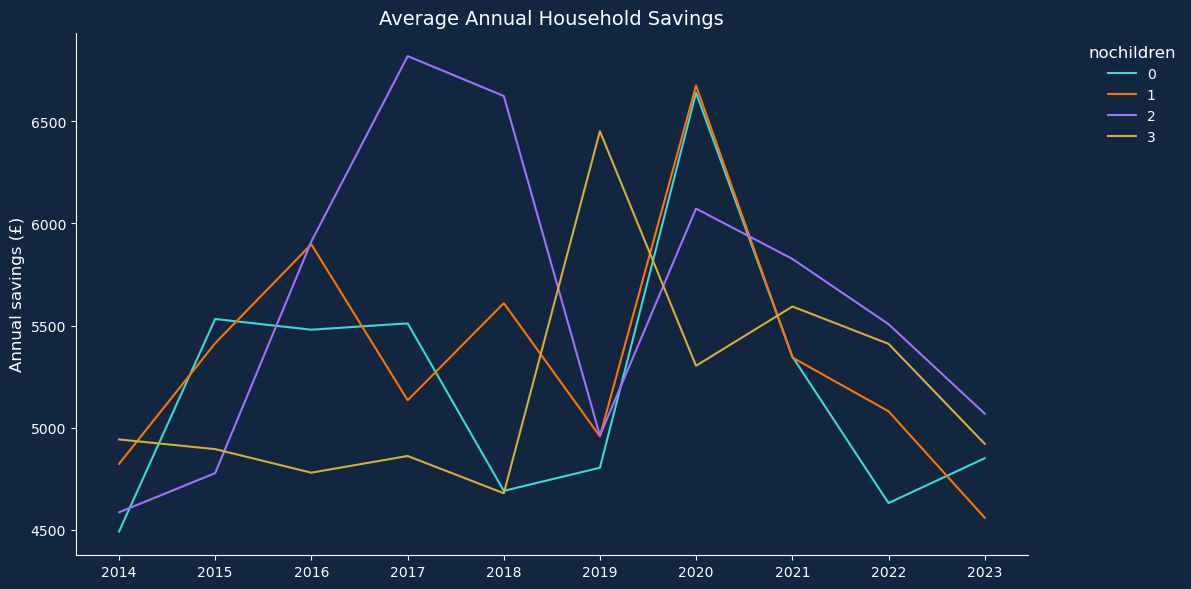

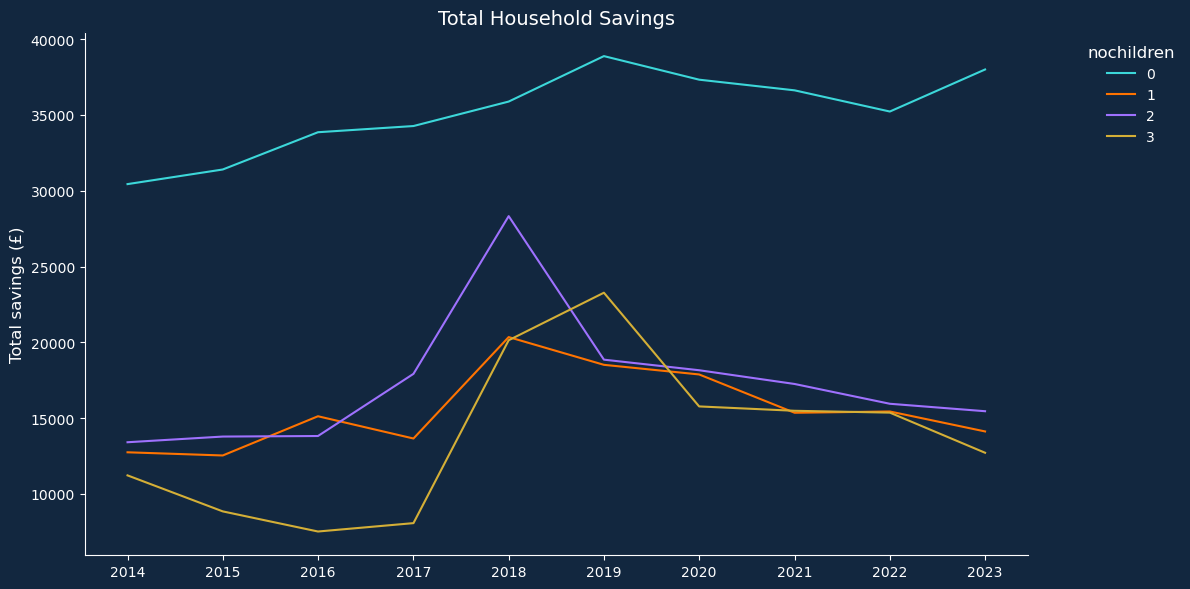

In [23]:
plot_savings(df = combined_df,
                              grouping = 'nochildren',
                              savings_var = 'x_annual_savings')
plot_savings(df = combined_df,
                              grouping = 'nochildren',
                              savings_var = 'x_boe65a')

In [24]:
# Renters as % by Age
renters = combined_df[combined_df['qhousing'] == 'Rented from a private landlord']

# Count total respondents and renters per age group
age_group_counts = combined_df['dage'].value_counts()  # Total respondents per age group
renters_by_age = renters['dage'].value_counts()  # Renters per age group

# Calculate percentage of renters by age group
renters_percentage_by_age = (renters_by_age / age_group_counts) * 100

# Convert to DataFrame for visualization
renters_percentage_df = renters_percentage_by_age.reset_index()
renters_percentage_df.columns = ['Age Group', 'Percentage of Renters']

# Sort by age group for clarity
renters_percentage_df.sort_values(by='Age Group', inplace=True)

# Display the result
print(renters_percentage_df)

  Age Group  Percentage of Renters
0   18 - 24              35.405137
1   25 - 34              32.077103
2   35 - 44              21.691956
3   45 - 54              13.539454
4   55 - 64               7.355882
5       65+               6.266271


/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_12273/563200829.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


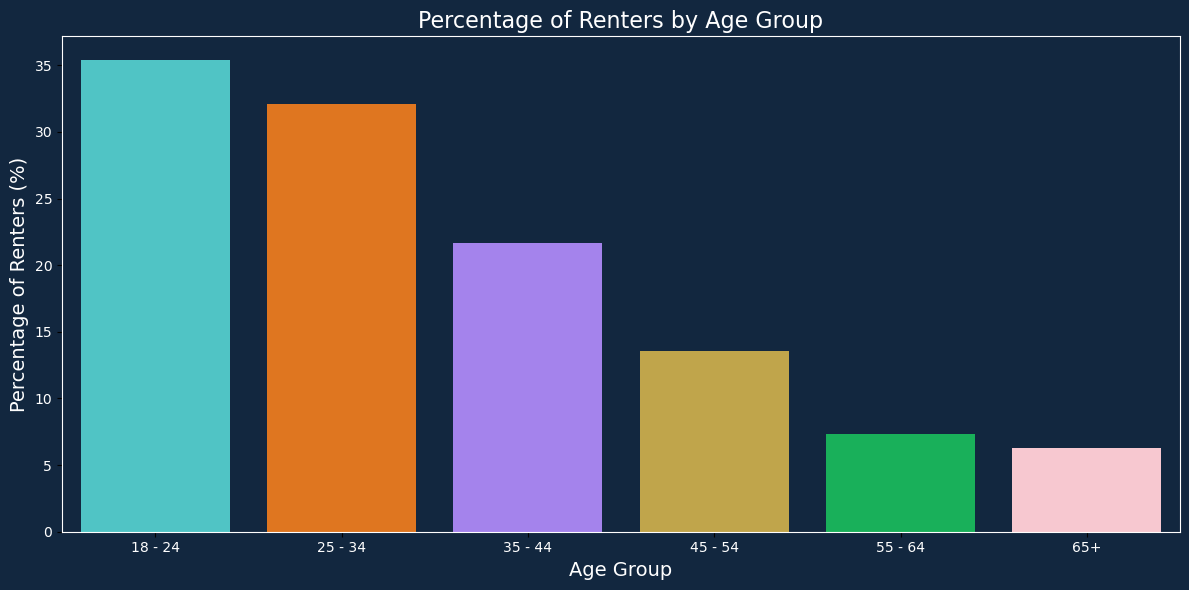

In [25]:
# Calculate percentages
renters = combined_df[combined_df['qhousing'] == 'Rented from a private landlord']
age_group_counts = combined_df['dage'].value_counts()
renters_by_age = renters['dage'].value_counts()
renters_percentage_by_age = (renters_by_age / age_group_counts) * 100

# Convert to DataFrame for visualization
renters_percentage_df = renters_percentage_by_age.reset_index()
renters_percentage_df.columns = ['Age Group', 'Percentage of Renters']
renters_percentage_df.sort_values(by='Age Group', inplace=True)

# Custom styling for the plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=renters_percentage_df,
    x='Age Group',
    y='Percentage of Renters',
    palette=['#3CD7D9', '#FF7300', '#9E71FE', '#D4AF37', '#00C957', '#FFC0CB']
)

# Customization
plt.title('Percentage of Renters by Age Group', fontsize=16, color='white')
plt.xlabel('Age Group', fontsize=14, color='white')
plt.ylabel('Percentage of Renters (%)', fontsize=14, color='white')
plt.xticks(color='white')
plt.yticks(color='white')

# Remove gridlines
plt.grid(False)

# Set background and spines
plt.gca().set_facecolor('#12273F')  # Background color of the plot
plt.gcf().set_facecolor('#12273F')  # Background color of the figure
ax = plt.gca()
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['right'].set_color('white')

# Show plot
plt.tight_layout()
plt.show()

## Machine Learning Development

Prepare data for modelling

In [39]:
# Convert 'date' to datetime and extract 'year'
interest_df['year'] = pd.to_datetime(interest_df['date']).dt.year
inflation_df['year'] = pd.to_datetime(inflation_df['date']).dt.year

# Aggregate interest rates and inflation rates by year
interest_annual = interest_df.groupby('year', as_index=False).agg({'bank_rate': 'mean'})
inflation_annual = inflation_df.groupby('year', as_index=False).agg({'cpih_annual_rate': 'mean'})

# Merge the two DataFrames on 'year'
rates_annual = pd.merge(interest_annual, inflation_annual, on='year', how='outer')
# Fill NaN values with the next available non-NaN value
rates_annual['bank_rate'] = rates_annual['bank_rate'].fillna(method='bfill')

df_to_model = combined_df[['year', 'fgenage_1', 'fgen', 'qregion', 'nochildren', 'x_boe65a', 'x_annual_savings']].dropna().copy()

df_to_model['year'] = pd.to_datetime(df_to_model['year']).dt.year
rates_annual['year'] = rates_annual['year'].astype(int)
merged_df = pd.merge(df_to_model, rates_annual, on='year', how='left')


/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_12273/1609510226.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rates_annual['bank_rate'] = rates_annual['bank_rate'].fillna(method='bfill')


,year,fgenage_1,fgen,qregion,nochildren,x_boe65a,x_annual_savings,bank_rate,cpih_annual_rate
23896,2018,70,Female,North,0.0,11250.0,14994.0,0.750,2.300000
7832,2015,54,Male,Greater London,1.0,0.0,0.0,0.250,0.366667
28090,2019,33,Female,Yorks & Humberside,3.0,125000.0,20994.0,0.175,1.750000
8742,2015,41,Male,East Anglia,0.0,16250.0,6594.0,0.250,0.366667
2517,2014,66,Male,Wales,0.0,87500.0,3294.0,0.250,1.450000
7274,2015,41,Female,East Midlands,2.0,0.0,2694.0,0.250,0.366667
1468,2014,29,Female,South East,4.0,250.0,0.0,0.250,1.450000
28425,2019,39,Female,Yorks & Humberside,2.0,2500.0,1494.0,0.175,1.750000
19541,2018,43,Female,South West,1.0,0.0,0.0,0.750,2.300000
4669,2014,48,Female,North West,1.0,150000.0,6594.0,0.250,1.450000


In [40]:

# Define features and target variable
features = ['fgenage_1', 'fgen', 'qregion', 'nochildren', 'x_boe65a', 'bank_rate', 'cpih_annual_rate']
target = 'x_annual_savings'

# Split into features (X) and target (y)
X = merged_df[features]
y = merged_df[target]

# Define preprocessing
numerical_features = ['fgenage_1', 'x_boe65a', 'bank_rate', 'cpih_annual_rate']
categorical_features = ['fgen', 'qregion', 'nochildren']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 49857511.31
R² Score: 0.16


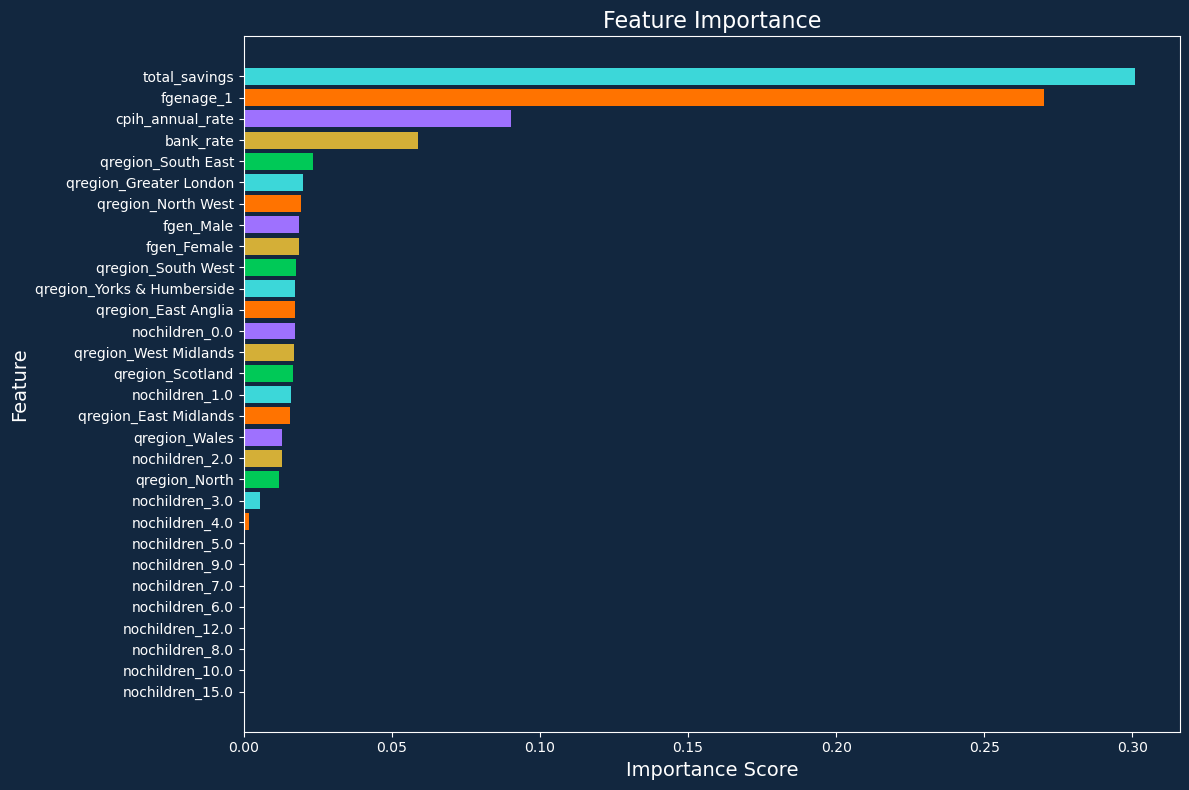

In [51]:
# Generate feature importance data
feature_importances = model.named_steps['regressor'].feature_importances_
feature_names = numerical_features + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())

# Replace 'x_boe65a' with 'total_savings'
feature_names = [name.replace('x_boe65a', 'total_savings') for name in feature_names]

# Sort features by importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(
    feature_importance_df['Feature'], 
    feature_importance_df['Importance'], 
    color=['#3CD7D9', '#FF7300', '#9E71FE', '#D4AF37', '#00C957']
)
plt.title('Feature Importance', fontsize=16, color='white')
plt.xlabel('Importance Score', fontsize=14, color='white')
plt.ylabel('Feature', fontsize=14, color='white')
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top

# Customize background and text colors
plt.gca().set_facecolor('#12273F')
plt.gcf().set_facecolor('#12273F')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Adjust spines
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_color('white')

plt.tight_layout()
plt.show()